In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

# train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each


In [4]:
trained_reasoner.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


<All keys matched successfully>

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.5, val_size=0.5):
    groups = data[group_col].unique()
    val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        val_data, test_data = train_test_split(group_data, test_size=test_size, stratify=data[stratify_col], random_state=seed)

        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[val_idx], data.loc[test_idx]

val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.5, val_size=0.5)


X_te_val = val_data['X'].tolist()
y_te_val = val_data['y'].tolist()
idx_te_val = val_data['ontology_id'].tolist()

data_te_vl = [idx_te_val, X_te_val, y_te_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [7]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/22 | batch 751/750 | loss 1.3681 | val loss 1.3720 | acc 0.5904 | f1 0.4052 | prec 0.2958 | recall 0.6429 | roc auc 0.6765 | pr auc 0.4963 | elapsed 8.76s
train epoch 01/22 | batch 751/750 | loss 1.2114 | val loss 1.0572 | acc 0.6542 | f1 0.4464 | prec 0.3420 | recall 0.6423 | roc auc 0.7187 | pr auc 0.5413 | elapsed 23.07s
train epoch 02/22 | batch 751/750 | loss 0.8961 | val loss 0.8088 | acc 0.7153 | f1 0.4978 | prec 0.4032 | recall 0.6503 | roc auc 0.7605 | pr auc 0.5921 | elapsed 18.02s
train epoch 03/22 | batch 751/750 | loss 0.6569 | val loss 0.6282 | acc 0.7700 | f1 0.5536 | prec 0.4782 | recall 0.6573 | roc auc 0.7997 | pr auc 0.6483 | elapsed 17.21s
train epoch 04/22 | batch 751/750 | loss 0.4876 | val loss 0.5028 | acc 0.8141 | f1 0.6123 | prec 0.5593 | recall 0.6763 | roc auc 0.8325 | pr auc 0.7037 | elapsed 16.44s
train epoch 05/22 | batch 751/750 | loss 0.3728 | val loss 0.4182 | acc 0.8471 | f1 0.6609 | prec 0.6371 | recall 0.6866 | roc au

In [8]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

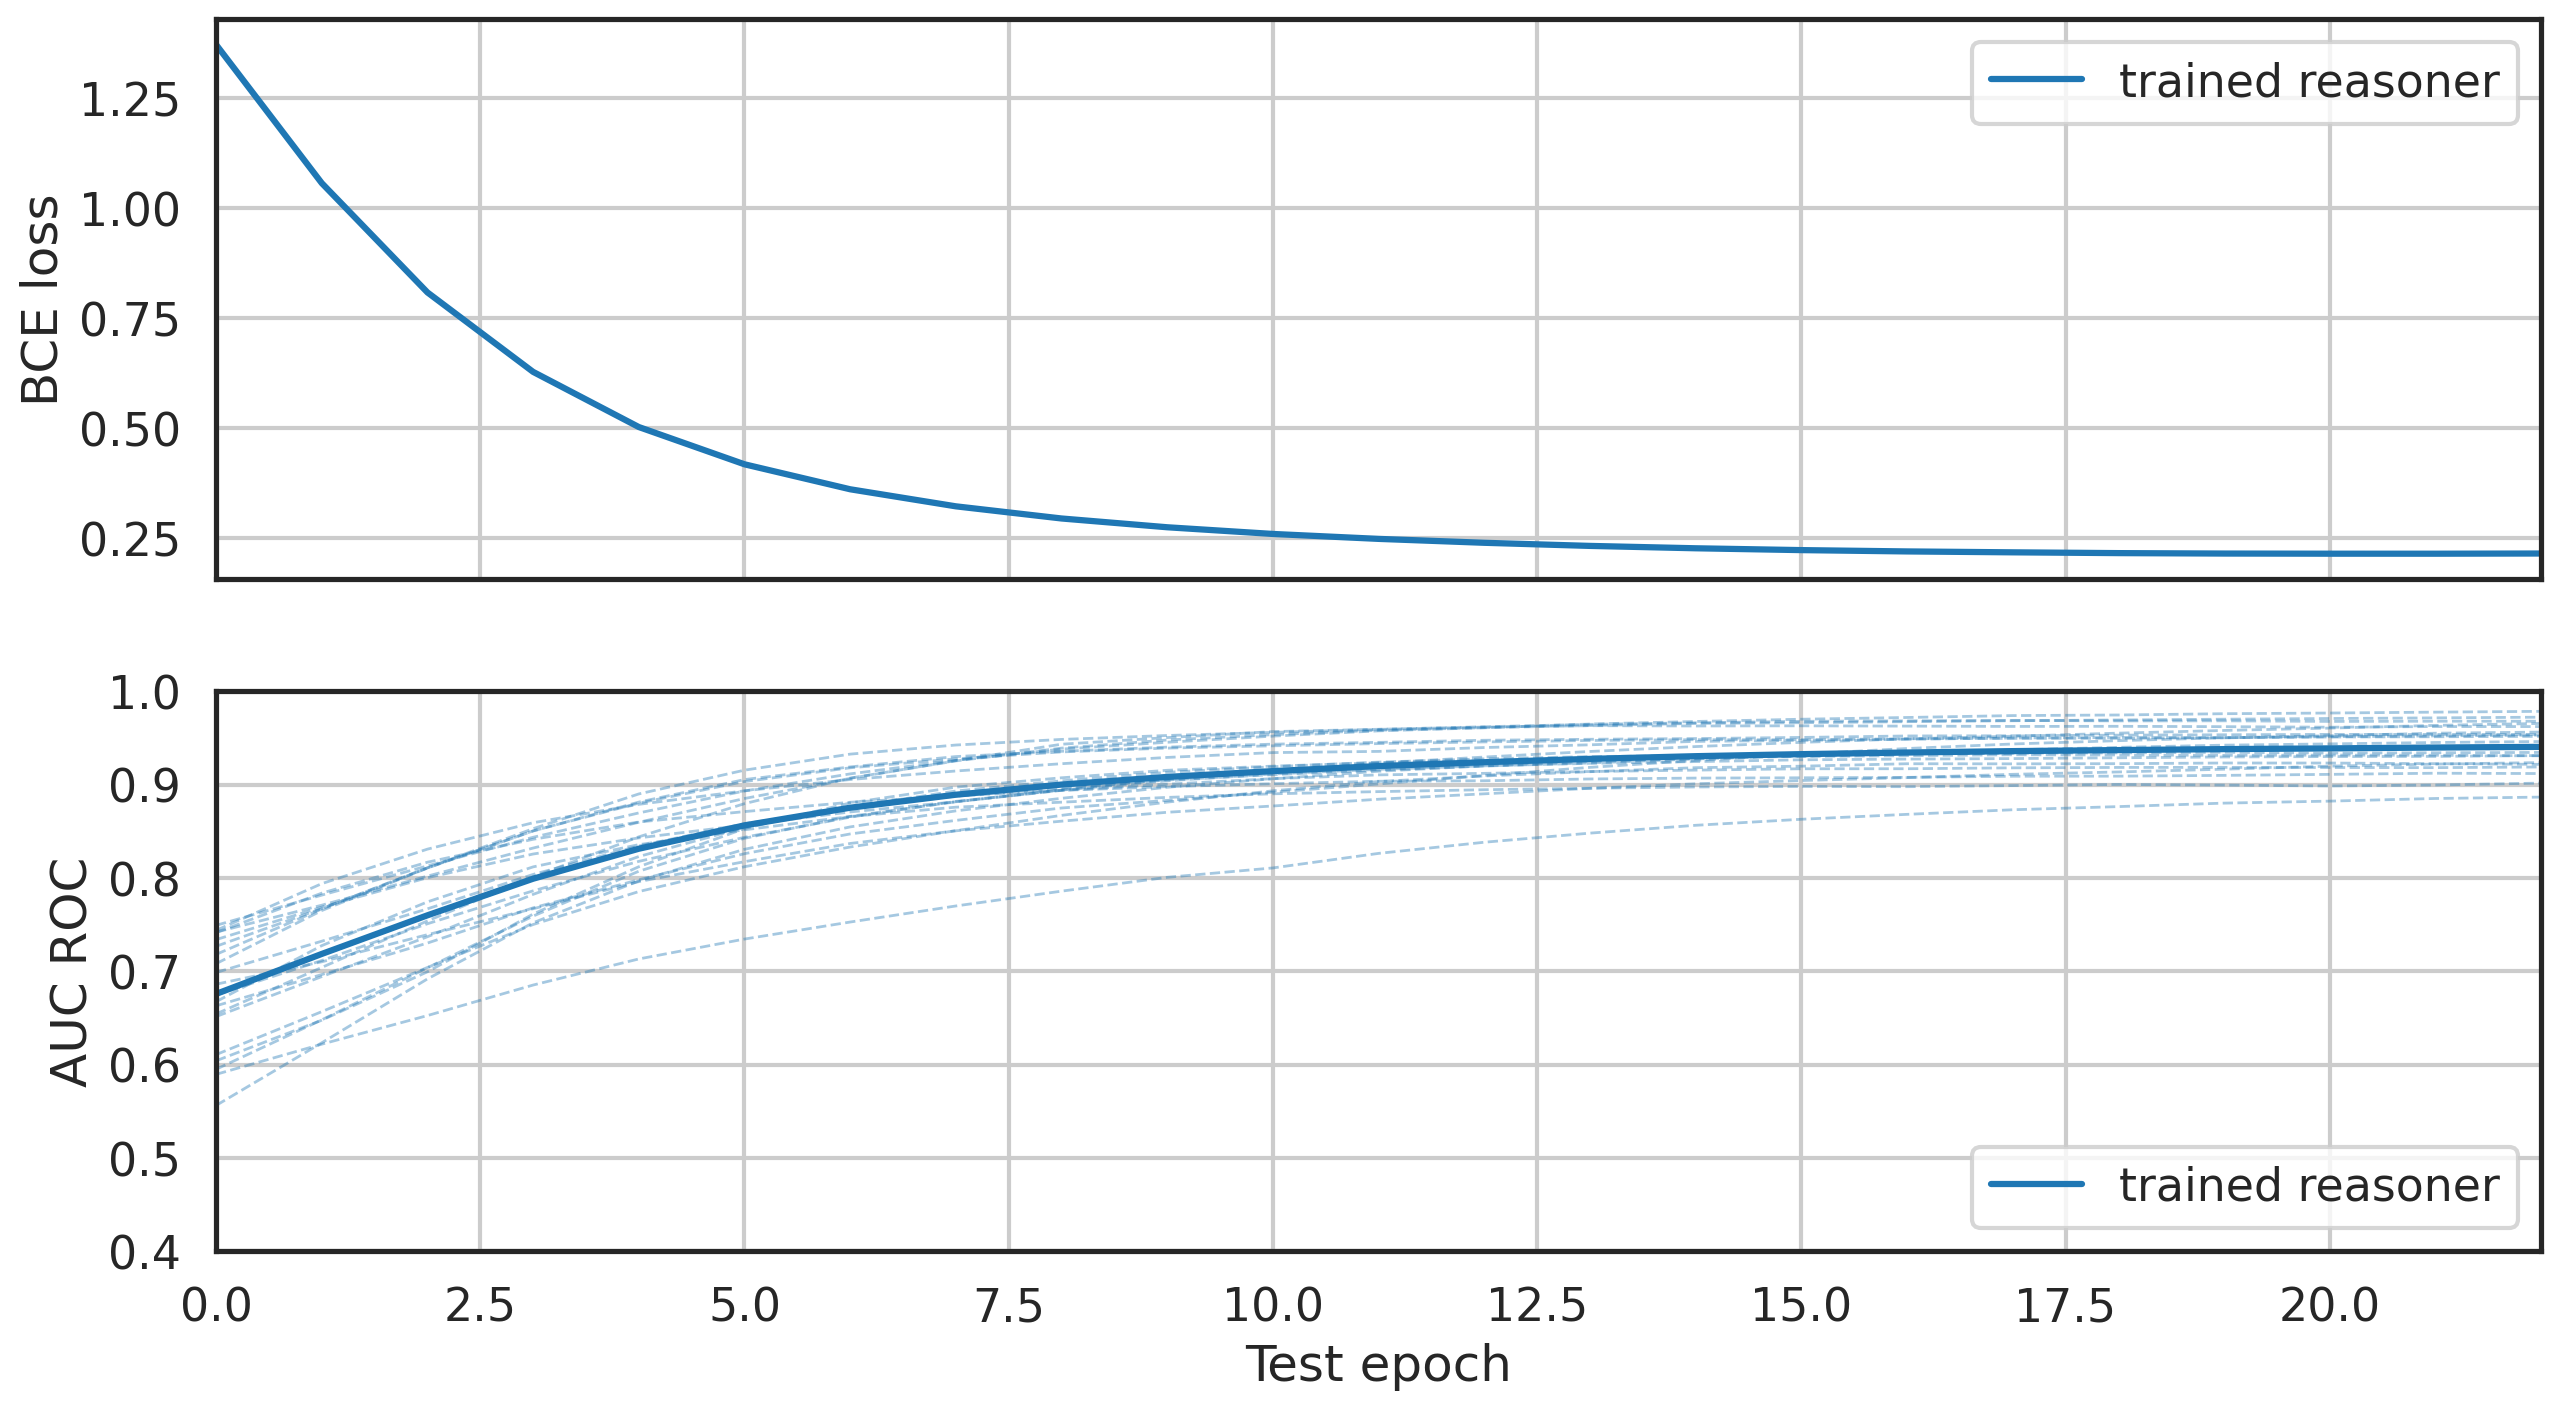

             mean       std     micro
acc      0.938750  0.021050  0.938750
prec     0.894840  0.053283  0.893777
recall   0.813796  0.061255  0.815835
f1       0.851324  0.049515  0.853029
auc_roc  0.945178  0.025088  0.947561
auc_pr   0.912442  0.038072  0.916282


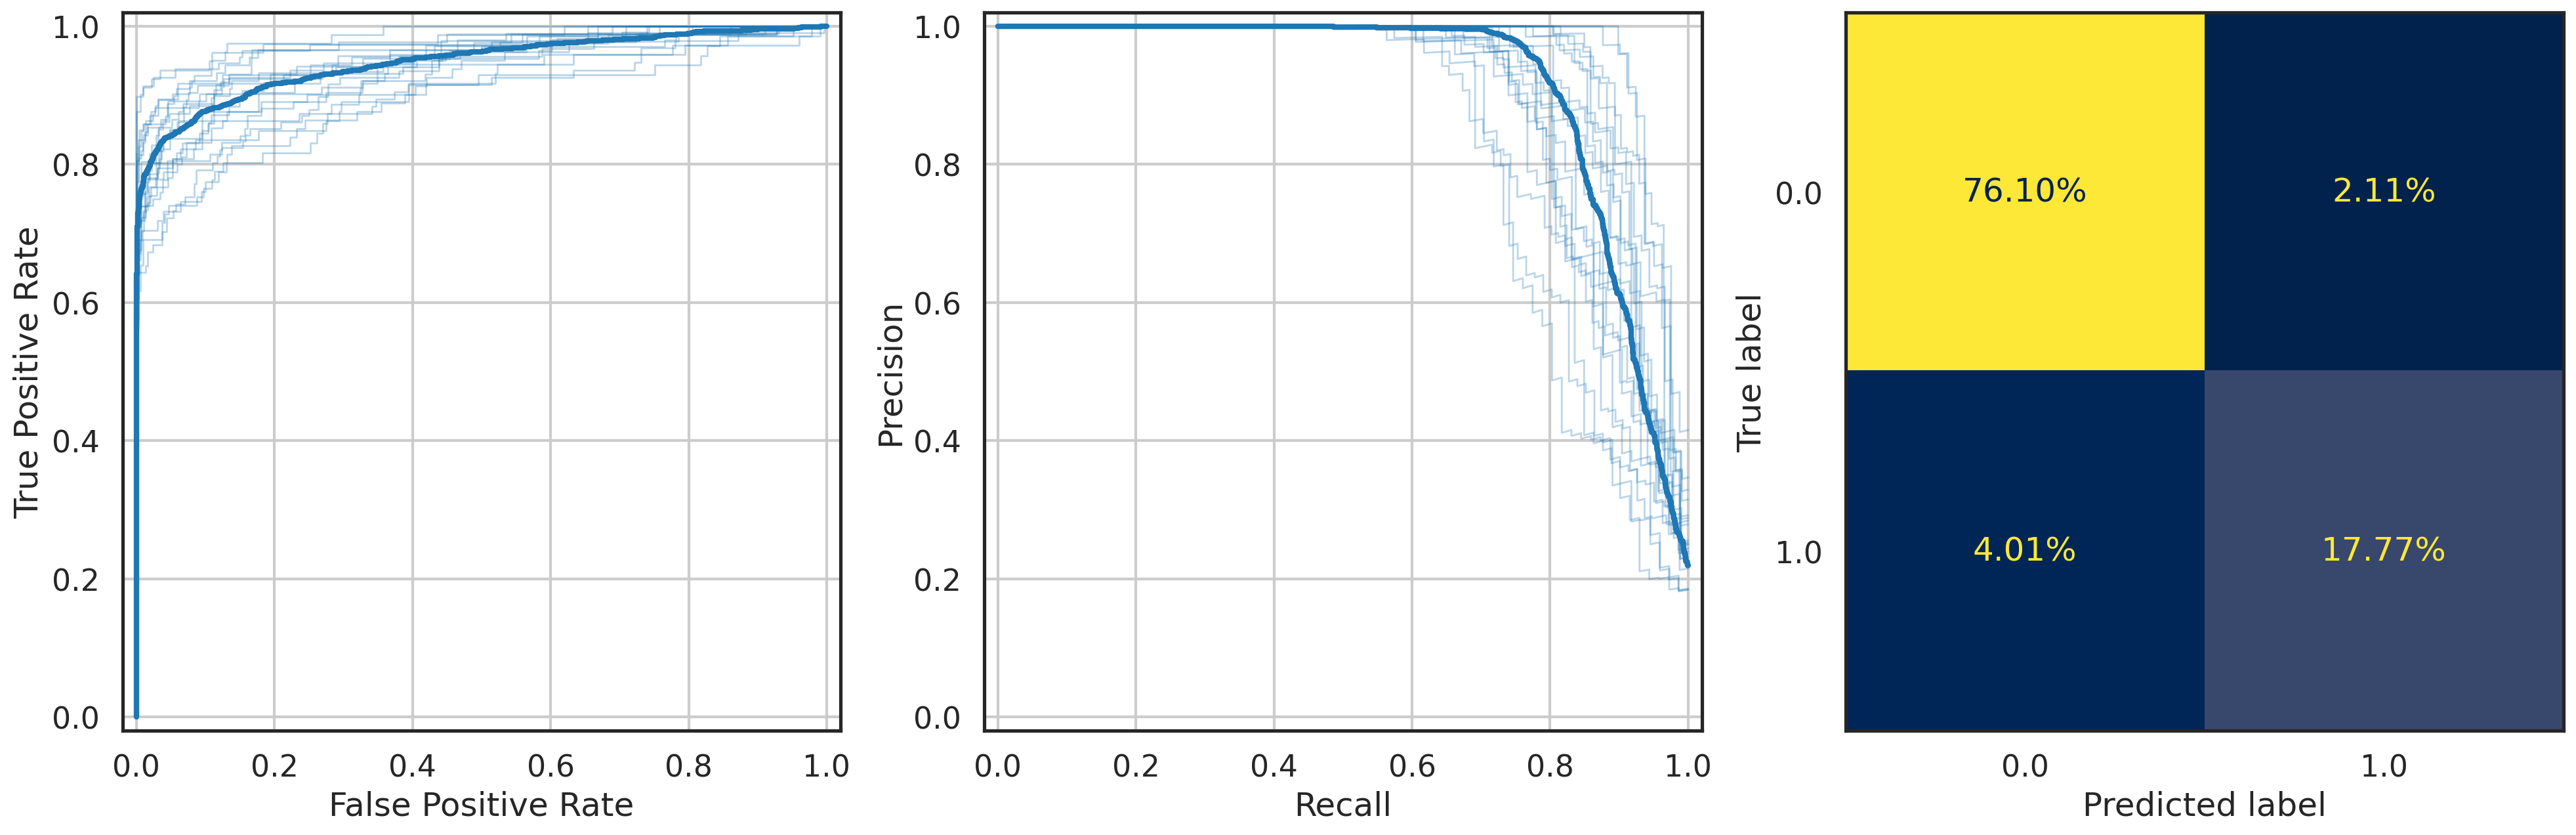

In [9]:
# base = 'local/out/exp/' + ts
# mkdirp(base)
# print(base)

# T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))
# test_history.to_csv(base+'/test.csv', index=False)
# test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
# test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te, np.array(Y_te_good), idx_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [21]:
import random

In [25]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([ 0.0069,  0.2089, -0.0167, -0.1341,  0.0950, -0.1029,  0.1490, -0.1670,
        -0.1131, -0.2965], grad_fn=<SelectBackward0>)
tensor([ 0.1314,  0.1314, -0.2142,  0.1222, -0.0161,  0.2074,  0.1191,  0.1198,
        -0.1284, -0.2304], grad_fn=<AddBackward0>)
0.140990100055933


In [26]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([-0.3034, -0.4222,  0.6476,  0.4729, -0.6379,  0.5930, -0.4687,  0.0676,
        -0.0402,  0.0658], grad_fn=<SelectBackward0>)
tensor([-0.4946, -0.4400,  0.3467,  0.1110,  0.3167,  0.3166,  0.2260, -0.4006,
         0.5490,  0.2442], grad_fn=<AddBackward0>)
0.40069243460893633


In [27]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.0841,  0.1928, -0.1249, -0.0086,  0.0225, -0.1031, -0.0012,  0.1109,
        -0.3833, -0.1387], grad_fn=<SelectBackward0>)
tensor([ 0.2574,  0.2618, -0.3254,  0.0309, -0.0333,  0.2953, -0.3505,  0.1552,
        -0.2065, -0.1911], grad_fn=<AddBackward0>)
0.17197869159281254


In [28]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([-0.3034, -0.4222,  0.6476,  0.4729, -0.6379,  0.5930, -0.4687,  0.0676,
        -0.0402,  0.0658], grad_fn=<SelectBackward0>)
tensor([ 0.0499, -0.0138,  0.0144,  0.1282,  0.0105,  0.2371,  0.1513,  0.0373,
         0.0067, -0.0988], grad_fn=<AddBackward0>)
0.3774100884795189


In [29]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([-0.3034, -0.4222,  0.6476,  0.4729, -0.6379,  0.5930, -0.4687,  0.0676,
        -0.0402,  0.0658], grad_fn=<SelectBackward0>)
tensor([ 0.0229,  0.2007,  0.7249,  0.5370, -0.0215,  0.0441, -0.1353,  0.2239,
         0.6622, -0.2826], grad_fn=<AddBackward0>)
tensor(0.3796, grad_fn=<L1LossBackward0>)


In [30]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.1090,  0.0754,  0.2614, -0.0397,  0.2937, -0.8621, -0.9519,  0.7124,
        -0.1034, -0.0492], grad_fn=<SelectBackward0>)
tensor([ 0.5670,  0.6208, -0.4071,  0.1943,  0.0985, -0.4068, -0.7802,  0.8731,
        -0.7390, -0.5552], grad_fn=<AddBackward0>)
tensor(0.4030, grad_fn=<L1LossBackward0>)


In [31]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([-0.1527, -0.1545,  0.1255,  0.0904,  0.0547,  0.2048,  0.2218, -0.1713,
         0.1747,  0.1337], grad_fn=<AddBackward0>)
tensor([-0.1716, -0.1837,  0.1123,  0.2181,  0.1363,  0.2455,  0.1373, -0.1551,
         0.1316,  0.0591], grad_fn=<AddBackward0>)
0.03361985459923744


In [32]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.0758,  0.1347, -0.2740,  0.1172, -0.0735,  0.1134,  0.0620,  0.1474,
        -0.1968, -0.1463], grad_fn=<AddBackward0>)
tensor([ 0.1079,  0.1737, -0.2493,  0.1454,  0.0250,  0.1265,  0.1826,  0.0822,
        -0.1880, -0.1712], grad_fn=<AddBackward0>)
0.04214125527068972


In [33]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.0821,  0.1424, -0.0778, -0.2660,  0.0712,  0.0124,  0.1763, -0.1278,
         0.0280,  0.1962], grad_fn=<SelectBackward0>)
tensor([ 0.0608,  0.2370, -0.0373,  0.3409,  0.1324,  0.1755,  0.1363,  0.0953,
        -0.1243, -0.1825], grad_fn=<AddBackward0>)
0.1588394183665514


In [34]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.999497601389885


In [35]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999992847442627
